# Understanding Political Sentiment on Twitter
> Authors: Meghan Mandi and Duncan Grubbs

In [2]:
# Python Libs
import re
import csv
import os
import datetime

# Sentiment & Text analysis libs
from wordcloud import WordCloud
from textblob import TextBlob

# plotting and math libs
import matplotlib.pylab
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

### Helper Functions and Lists

In [6]:
leaders_accounts = [
    'realDonaldTrump',
    'BernieSanders',
    'JoeBiden',
    'JustinTrudeau',
    'lopezobrador_',
    'narendramodi',
    'BorisJohnson',
    'MBuhari',
    'PresidencyZA',
    'KingSalman',
    'ScottMorrisonMP',
    'EmmanuelMacron',
    'IsraeliPM'
]

six_month_accs = [
    'EmmanuelMacron',
    'lopezobrador_',
    'narendramodi'
]

In [35]:
def clean_tweet(tweet):
    tweet = tweet.lower()
    regs = [
        r'(\/\/www[^\s]+)',
        r'(pic.twitter.com\/[^\s]+)',
        r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)',
        r'(?i)\b((?:https?:\/\/[^\s]+))'
    ]
    prev = tweet
    for reg in regs:
        prev = re.sub(reg, " ", prev)
    return prev

def get_tweets_list(account):
    tweets = []
    with open(f'./data/{account}.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        keys = next(csv_reader)
        for row in csv_reader:
            tweet = {}
            tweet[keys[0]] = row[0]
            tweet[keys[1]] = row[1]
            tweet[keys[6]] = clean_tweet(row[6])
            tweets.append(tweet)
    return tweets

def get_tweets(username):
    l = get_tweets_list('realDonaldTrump')
    l.reverse()
    return l

In [7]:
# verify start and end data for all accounts
for acc in leaders_accounts:
    tl = get_tweets_list(acc)
    s = tl[0]['date']
    e = tl[-1]['date']
    if (s[:4] != '2019' or e[:4] != '2015'):
        if (acc not in six_month_accs):
            print(f'acc: {acc}, start: {s}, end: {e}')

### Wordclouds
First, let's compare some of the worlds biggest leaders tweets by looking at wordclouds.

In [25]:
def generate_wordcloud(tweets):
    tweets_con = ''
    for t in tweets:
        tweets_con += t['text']
    return WordCloud(background_color='white', width=1000, height=600).generate(tweets_con)

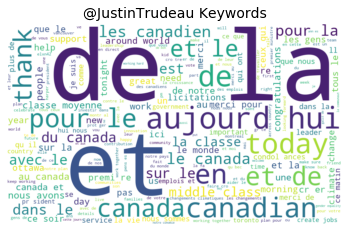

In [31]:
wc_list = [
    'realDonaldTrump',
    'BorisJohnson',
    'narendramodi',
    'JustinTrudeau'
]

def plot_wordcloud(wc, title):
    plt.title(title, fontsize=14)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f'./blog_res/{title}.png', dpi=400)
    
for acc in wc_list:
    t_list = get_tweets_list(acc)
    t_list.reverse()
    wc = generate_wordcloud(t_list)
    plot_wordcloud(wc, f'@{acc} Keywords')

### Basic Analysis

In [36]:
main_accounts = [
    'realDonaldTrump',
    'JustinTrudeau',
    'lopezobrador_',
    'narendramodi',
    'BorisJohnson',
    'MBuhari',
    'KingSalman',
    'ScottMorrisonMP',
    'EmmanuelMacron'
]

num_tweets = {}
len_tweets = {}

for acc in main_accounts:
    with open(f'./data/{acc}.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        num = len(list(csv_reader)) - 1
        num_tweets[acc] = num
        
for acc in main_accounts:
    with open(f'./data/{acc}.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        keys = next(csv_reader)
        avg = 0
        for row in csv_reader:
            avg += len(row[6])
        avg /= num_tweets[acc]
        len_tweets[acc] = avg
        
sorted_nums = {k: v for k, v in sorted(num_tweets.items(), key=lambda item: item[1])}
sorted_lens = {k: v for k, v in sorted(len_tweets.items(), key=lambda item: item[1])}

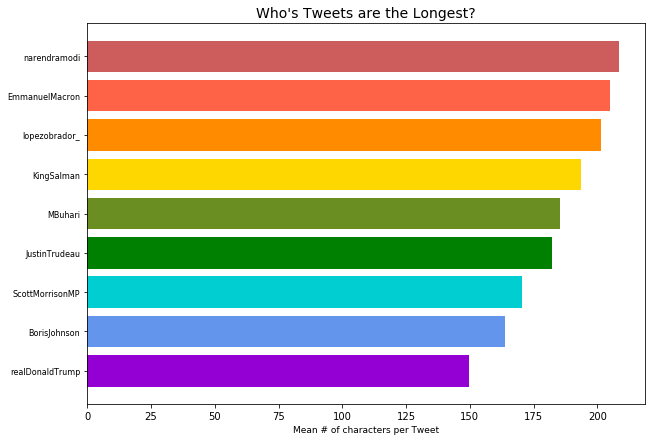

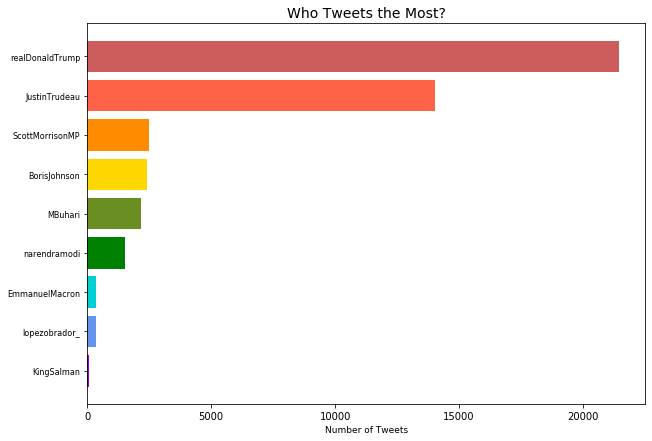

In [37]:
colors = ['indianred',
          'tomato',
          'darkorange',
          'gold',
          'olivedrab',
          'green',
          'darkturquoise',
          'cornflowerblue',
          'darkviolet']
colors.reverse()

def plot_num_tweets_comp():
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.barh(
        list(sorted_nums.keys()),
        list(sorted_nums.values()),
        align='center',
        color=colors)
    plt.yticks(fontsize=8)
    plt.xlabel('Number of Tweets', fontsize=9)
    plt.title('Who Tweets the Most?', fontsize=14)
    plt.savefig('num_comp.png', dpi=400)
    plt.show()
    
def plot_len_tweets_comp():
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.barh(
        list(sorted_lens.keys()),
        list(sorted_lens.values()),
        align='center',
        color=colors)
    plt.yticks(fontsize=8)
    plt.xlabel('Mean # of characters per Tweet', fontsize=9)
    plt.title('Who\'s Tweets are the Longest?', fontsize=14)
    plt.savefig('length_comp.png', dpi=400)
    plt.show()
    
plot_len_tweets_comp()
plot_num_tweets_comp()

### Analysis Helper Methods

In [82]:
def inRange(tweet, start, end):
    date = tweet['date'][:10]
    s = datetime.datetime.strptime(start, "%Y-%m-%d")
    e = datetime.datetime.strptime(end, "%Y-%m-%d")
    check = datetime.datetime.strptime(date, "%Y-%m-%d")
    if s <= check <= e:
        return True
    return False

def get_tweets_range(tweets, start, end):
    active = False
    sub_section = []
    for tweet in tweets:
        if (inRange(tweet, start, end)):
            sub_section.append(tweet)
    return sub_section

assert len(get_tweets_range(trump_tweets, '2016-04-13', '2017-04-13')) == 2990

### Sentiment Analysis

In [28]:
def average_sent(tweets):
    pol = []
    sub = []
    time = []
    for year in range(16, 20):
        for month in range(1, 13, 2):
            if (month < 10):
                start = f'20{year}-0{month}-01'
            else:
                start = f'20{year}-{month}-01'
            if (month + 1 < 10):
                end = f'20{year}-0{month+1}-30'
            else:
                end = f'20{year}-{month}-30'
            tweet_ir = get_tweets_range(tweets, start, end)
            p = 0
            s = 0
            for tweet in tweet_ir:
                ss = TextBlob(tweet['text']).sentiment
                p += ss[0]
                s += ss[1]
            if (len(tweet_ir) != 0):
                p /= len(tweet_ir)
                s /= len(tweet_ir)
            pol.append(p)
            sub.append(s)
            time.append(start)
    return (pol, sub), time

sent, time = average_sent(trudeau_tweets)

In [29]:
def sentiment_over_time(tweets, jump):
    '''
    Return sentiment and time arrays for plotting
    where the sentiment is retrived with the TextBlob library.
    This returns both subjectivity and polarity.
    '''
    pol = []
    sub = []
    time = []
    it = int(len(tweets)/jump)
    for tweet in tweets[0::it]:
        ss = TextBlob(tweet['text']).sentiment
        pol.append(ss[0])
        sub.append(ss[1])
        date = tweet['date'].split(' ')[0]
        time.append(date)
    return (pol, sub), time

def length_over_time(tweets, jump):
    '''Return the tweet length over time. (i.e length and time arrays)'''
    lengths = []
    time = []
    it = int(len(tweets)/jump)
    for tweet in tweets[0::it]:
        lengths.append(len(tweet['text']))
        date = tweet['date'].split(' ')[0]
        time.append(date)
    return lengths, time

def plot_length_over_time(lengths, t, title):
    plt.figure(figsize=(12, 9))
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=10)
    plt.xticks(rotation=90)
    plt.xlabel("Date", fontsize=16)  
    plt.ylabel("# of Characters", fontsize=16)  
    plt.plot(t, lengths, color="#3F5D7D", marker='o')
    plt.show()

def plot_sentiment_over_time(sent, time, title):
    plt.figure(figsize=(12, 9))
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=10)
    plt.xticks(rotation=90)
    plt.xlabel('Date', fontsize=16)  
    plt.ylabel('Sentiment Score', fontsize=16)  
    plt.plot(time, sent[0], label='Polarity', color='#3F5D7D', marker='o')
    plt.plot(time, sent[1], label='Subjectivity', color='orange', marker='o')
    plt.legend(loc='lower left', fontsize=14)
#     plt.savefig('sentiment.png', dpi=300)
    plt.show()
    
def plot_sentiment_scatter(sent1, sent2, title):
    plt.figure(figsize=(12, 9))
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=10)
    plt.xticks(rotation=90)
    plt.xlabel('Polarity (lower is better)', fontsize=16)  
    plt.ylabel('Subjectivity (close to 0 is better)', fontsize=16)  
    plt.scatter(sent1[1], sent1[0], label='Trudeau', color='#3F5D7D')
    plt.scatter(sent2[1], sent2[0], label='Trump', color='orange')
#     plt.savefig('sentiment.png', dpi=300)
    plt.legend(loc='lower left', fontsize=14)
    plt.show()
    
def get_tweets_with_keyword(tweets, keyword):
    new_tweets = [tweet for tweet in tweets if keyword in tweet['text']]
    return new_tweets

In [34]:
# ll, tt = length_over_time(trump_tweets)
# plot_length_over_time(ll, tt, 'Boris\'s Tweet Length Over Time')

sent, time = sentiment_over_time(trudeau_tweets, 10)

# sent1, time = tb_sentiment_over_time(trudeau_tweets, 500)
# sent2, time = tb_sentiment_over_time(trump_tweets, 500)

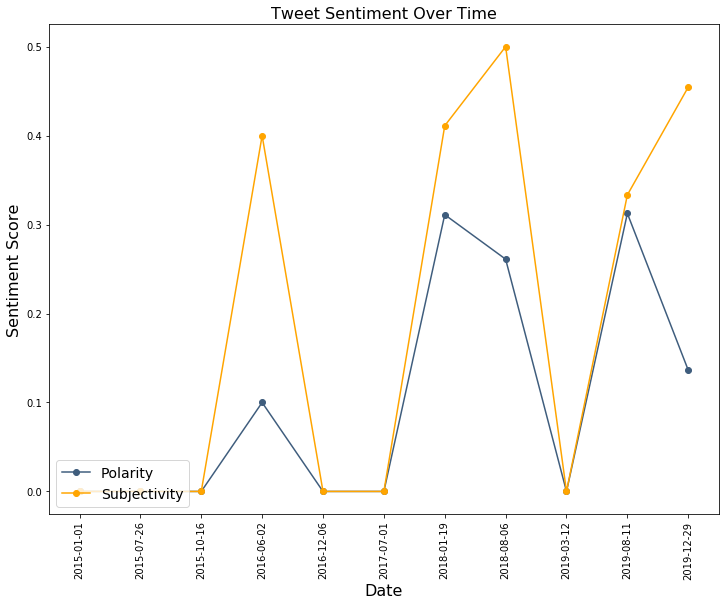

In [35]:
plot_sentiment_over_time(sent, time, 'Tweet Sentiment Over Time')
# plot_sentiment_scatter(sent1, sent2, 'Tweet Sentiment Trump vs. Trudeau')